# Forecast skill

Showcasing model evaluation for forecasting when using modelskill

In [454]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import modelskill as ms

In [455]:
# n_obs = 4

# date_range = pd.date_range("14-06-24", periods=n_obs, freq="d")
# date_range.name = "date"

# results_model_1 = pd.DataFrame(
#     {
#         1: [1.5, 1.2, 0.9, 0.5],
#         2: [0.7, 1.0, 0.8, 0.6],
#         3: [1.1, 1.3, 0.5, 1.0],
#     },
#     index=date_range
# )

# results_model_2 = pd.DataFrame(
#     {
#         1: [1.4, 0.72, 1.9, 0.7],
#         2: [0.4, 1.2, 1.2, 0.3],
#         3: [1.4, 1.3, 0.2, 1.1],
#     },
#     index=date_range
# )

# observations = pd.DataFrame(
#     {"observation": [1.5, 1.1, 0.9, 0.6]},
#     index=date_range
# )

In [456]:
results_model_1 = pd.read_csv("../tests/testdata/forecast_skill/model_1.csv", parse_dates=True, index_col=0)
results_model_2 = pd.read_csv("../tests/testdata/forecast_skill/model_2.csv", parse_dates=True, index_col=0)

results_model_1.columns = [int(cname) for cname in results_model_1.columns]
results_model_2.columns = [int(cname) for cname in results_model_2.columns]

observations = pd.read_csv("../tests/testdata/forecast_skill/observations.csv", parse_dates=True, index_col=0)

We include a column representing lead time 0, which are the observations. This will serve later to define the starting point for evaluating the skill trend with lead time.

In [457]:
results_model_1[0] = observations["observation"]
results_model_2[0] = observations["observation"]

We want to combine the results of each model and the observations in a single dataframe. In order to do that, we can

A) use the `modelskill` class `ComparerCollection`:

In [458]:
obs = ms.PointObservation(observations)
ms.match(obs=obs, mod=ms.PointModelResult(results_model_1[1], name="model_1_1"))

list_of_comparers_1 = [ms.match(obs=obs, mod=ms.PointModelResult(results_model_1[i], name=f"model_1.{i}")) for i in range(0, 7 + 1)]
list_of_comparers_2 = [ms.match(obs=obs, mod=ms.PointModelResult(results_model_2[i], name=f"model_2.{i}")) for i in range(0, 7 + 1)]
cc = ms.ComparerCollection(list_of_comparers_1 + list_of_comparers_2)

skill_A = cc.skill().to_dataframe()

In [459]:
def get_model_name(x, sep="."):
    return x[0].split(sep)[0]

def get_lead_time(x, sep="."):
    return x[0].split(sep)[1]

skill_A["model"] = skill_A.index.to_series().apply(get_model_name)
skill_A["lead_time"] = skill_A.index.to_series().apply(get_lead_time)

skill_A.reset_index(drop=True, inplace=True)
index_tuples = list(skill_A[["model", "lead_time"]].itertuples(index=False, name=None))
skill_A.index = pd.MultiIndex.from_tuples([model_j for model_j in index_tuples], names=['model', 'lead_time'])
skill_A = skill_A.sort_index().drop(columns=["model", "lead_time"])

B) Otherwise, we can merge the initial dataframes first, and only at the end consolidate the skill results:

In [460]:
melted_results_model_1 = pd.melt(results_model_1.reset_index(), id_vars=["time"], var_name="lead_time", value_name="model_1").dropna()
melted_results_model_2 = pd.melt(results_model_2.reset_index(), id_vars=["time"], var_name="lead_time", value_name="model_2").dropna()

matched_model_results = melted_results_model_1.merge(melted_results_model_2, how="inner", on=["time","lead_time"]).set_index("time").sort_index()
matched_model_results = matched_model_results.merge(right=observations, how="inner", left_index=True, right_index=True)

models = ["model_1", "model_2"]
comparers = {}
for model in models:
    comparers[model] = ms.from_matched(matched_model_results, mod_items=[model], aux_items=["lead_time"], obs_item="observation")

list_of_skilltables = []
for model, comparer in comparers.items():
    sk1 = comparer.skill(by="lead_time").to_dataframe(drop_xy=True)
    sk1.index = pd.MultiIndex.from_tuples([(model, j) for j in sk1.index], names=['model', 'lead_time'])
    list_of_skilltables.append(sk1.sort_index())

skill_B = pd.concat(list_of_skilltables).drop(columns="observation")

## Plotting

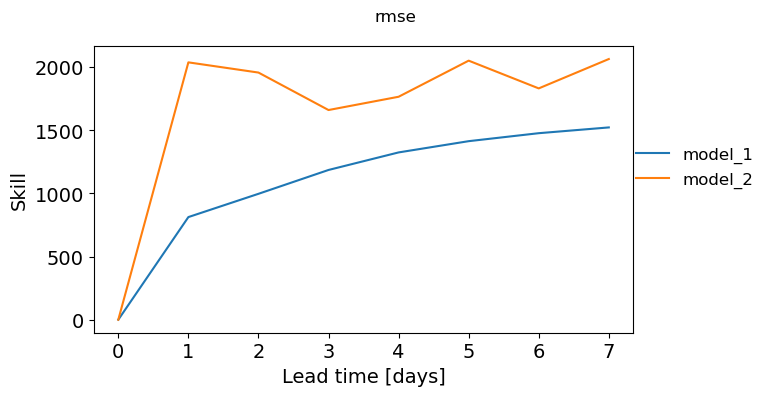

In [470]:
metric = "rmse"

sk = skill_A.reset_index()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(
    data=sk,
    x="lead_time",
    y=metric,
    hue="model",
    ax=ax,
)
fig.suptitle(f"{metric}")

ax.set_xlabel("Lead time [days]", fontsize=14)
ax.set_ylabel("Skill", fontsize=14)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.25, 0.7)),
ax.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.show()

The previous plot only shows one value for each lead time; however, it can be interesting see evaluate how the errors are distributed. The following section shows how to plot how the distribution of error changes as the lead time grows.

### Violin plots

The skilltable returns one value per category, e.g. (model_1, lead_time=2) and we would like to have a collection of points to draw the distribution. For this reason, we cannot generate the plot from the skill. Instead, we use the raw dataframe that contains all observations per model and lead_time.

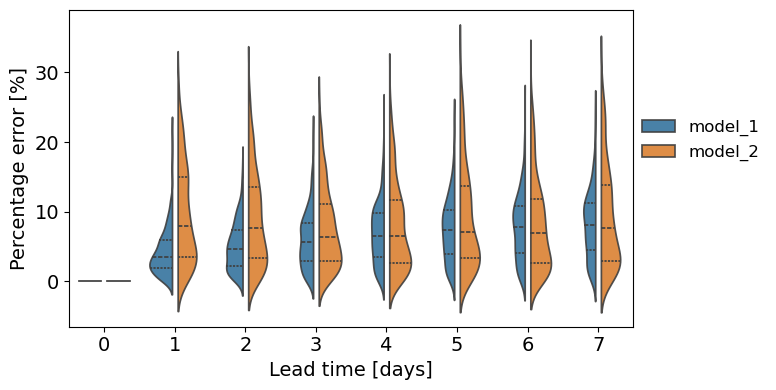

In [469]:
df1 = pd.melt(matched_model_results.reset_index(), id_vars=["time", "lead_time", "observation"], var_name="model")

df1["error"] = df1["observation"] - df1["value"]
df1["absolute_error"] = abs(df1["error"])
df1["percentage_error"] = 100 * df1["absolute_error"] / df1["observation"]

ylabel_dict = {"error": "Error", "absolute_error": "Absolute error", "percentage_error": "Percentage error [%]"}
errorcol = "percentage_error"

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(data=df1, x="lead_time", y=errorcol, hue="model", split=True, gap=0.2, inner="quarts", ax=ax, alpha=0.9, saturation=0.7)

ax.set_xlabel("Lead time [days]", fontsize=14)
ax.set_ylabel(ylabel_dict[errorcol], fontsize=14)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.25, 0.7))
ax.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.show()